In [1]:
"""Test"""
#importing the libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
import os

In [2]:
def load_train_data():
  results_path = f"../imputed_data/"
  file_name = f"numuser_370_L_80_dim_78_missingPercentage_20.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [4]:
def load_test_data():
  results_path = f"../test_data/"
  file_name = f"test_data_336steps.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [63]:
from torch.utils.data import Dataset
import torch
# Create dataset
class timeseries(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.len = x.shape[0]
    # print(self.len)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 
  
  def __len__(self):
    return self.len

In [3]:
train_data = load_train_data()
train_data.shape

(370, 25920)

In [5]:
test_data = load_test_data()
test_data.shape

(370, 336)

In [7]:
# Define the test settings
window = 40
prediction_steps = 24
num_users = 20

In [9]:
# Get the last window of train data
last_window = train_data[:, -window:]

# Get actual data for prediction steps
actual_steps = test_data[:, -prediction_steps:]

last_window.shape, actual_steps.shape

((370, 40), (370, 24))

In [40]:
def create_np_data(user_test_data, prediction_steps=24):
    x_test = []
    y_test = []

    for i in range(prediction_steps):
        x_test.append(user_test_data[i:i+window])
        y_test.append(user_test_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test

In [37]:
def load_model():
    # model_path = "server.pt"
    model_path = os.path.join("models", "Imputed_Elec370", "server" + ".pt")
    assert (os.path.exists(model_path))
    model = torch.load(model_path)

    return model

In [32]:
%cd ../../

/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA


In [33]:
!pwd

/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA


In [38]:
model = load_model()
model

LSTM_nn(
  (lstm): LSTM(1, 5, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

/home/tung6100/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


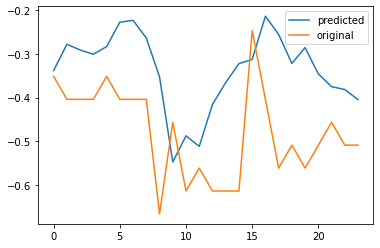

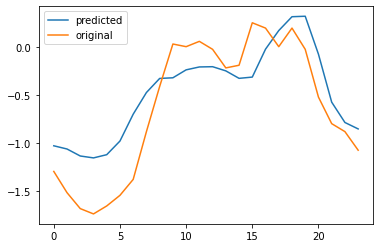

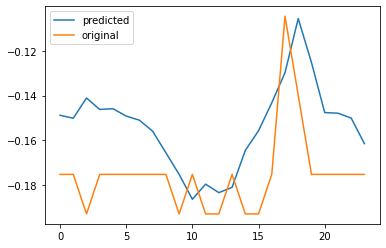

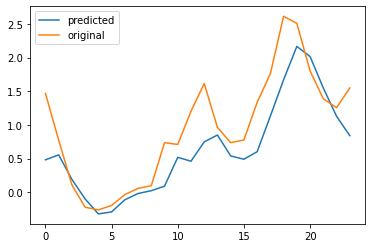

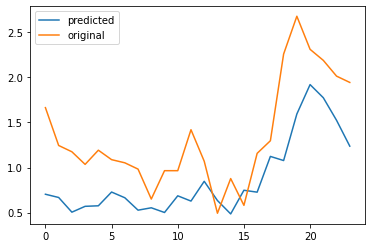

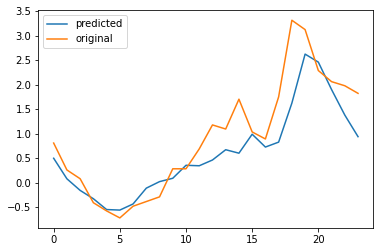

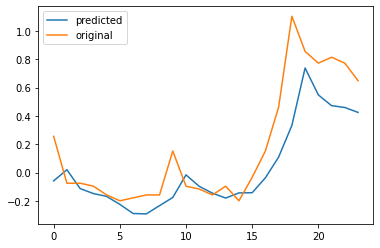

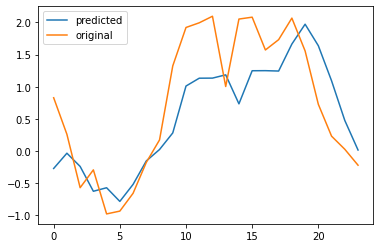

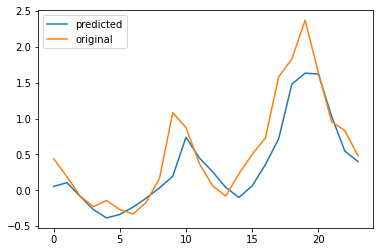

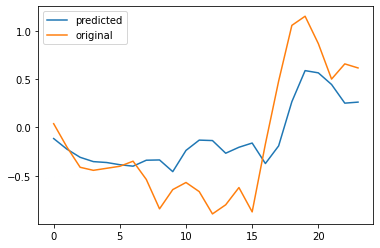

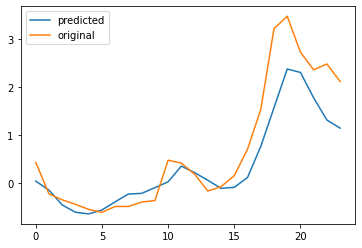

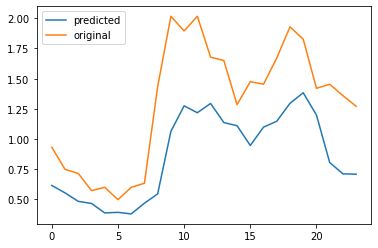

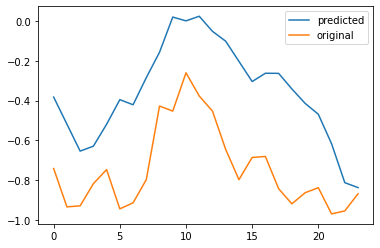

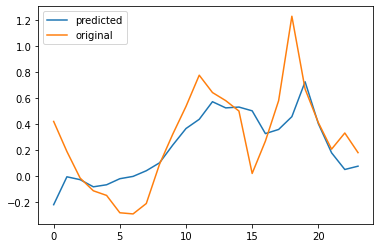

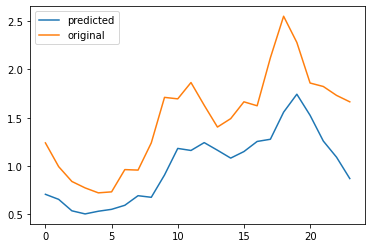

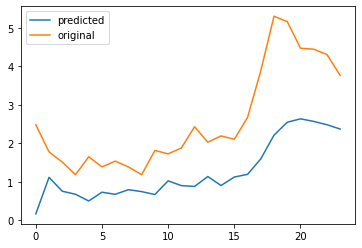

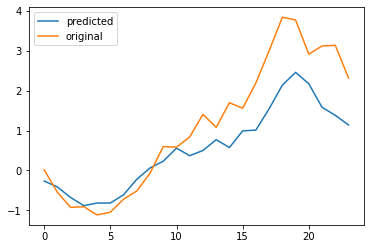

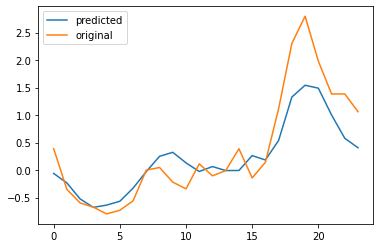

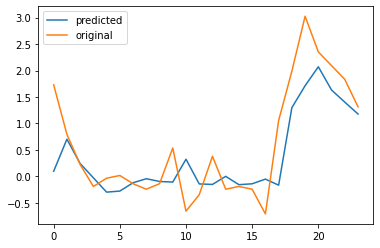

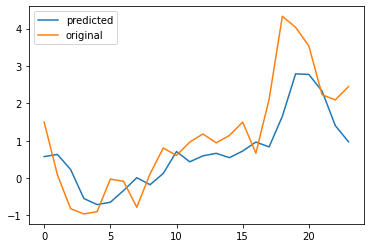

RMSE FedMSSA + LSTM: 0.6093813180923462


In [64]:
diff_list = []
for user_id in range(num_users):
    user_last_window = last_window[user_id]
    user_actual_steps = actual_steps[user_id]
    user_test_data = np.concatenate((user_last_window, user_actual_steps), axis=None)
    # print(f"{user_last_window.shape}, {user_actual_steps.shape}, {user_test_data.shape}")

    """Create input data for data model"""
    # Create np data
    x_test, y_test = create_np_data(user_test_data=user_test_data, prediction_steps=prediction_steps)
    # Cretate dataset
    test_set = timeseries(x_test, y_test)
    # Prediction
    input = test_set[:][0].view(-1,window,1)
    actual = test_set[:][1].view(-1)
    input = input.to(device)
    test_pred = model(input).view(-1)
    predictions_24 = test_pred.cpu().detach().numpy()
    actual = actual.numpy()
    diff = predictions_24 - actual
    diff_list.append(diff)
    plt.plot(predictions_24, label='predicted')
    plt.plot(actual, label='original')
    plt.legend()
    plt.plot()
    plt.show()
    # break
diff_np = np.array(diff_list)
rmse = np.sqrt(np.mean(np.square(diff_np)))
print(f"RMSE FedMSSA + LSTM: {rmse}")